# State evolution for experimental testing of SPA - J = 1
Performing state evolution for molecules coming out of State Preparation Region A *after* the state preparation has been done. Thus interested primarily in the evolution of the J = 2, mJ = 0 states as the electric field is ramped down in the absence of microwaves. Here doing the simulation for J = 1 states rather than J = 2

## Import packages

In [33]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.style.use(["seaborn-dark"])
plt.rcParams["figure.figsize"] = (16, 9)
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 24
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["font.family"] = 'serif'

import numpy as np

import centrex_TlF
from centrex_TlF import UncoupledBasisState
from state_prep.electric_fields import ElectricField, E_field_ring
from state_prep.hamiltonians import SlowHamiltonian
from state_prep.magnetic_fields import MagneticField
from state_prep.simulator import Simulator
from state_prep.trajectory import Trajectory
from state_prep.utils import vector_to_state

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define molecule trajectory
Defining the molecule trajectory as a Trajectory object. Specifying the initial position as z = 50 mm, i.e. 50mm  after the center of the microwaves is, and on the axis of the beamline. Taking the beam velocity to be 200 m/s in the z-direction. The simulation ends when `zfin` is reached, 200 mm from the microwwaves.

In [72]:
trajectory = Trajectory(Rini = np.array((0,0,50e-3)), Vini = np.array((0,0,200.)), zfin = 1000e-3)

## Define electric field
Defining an electric field that is an approximation of what the molecules should see in the real experiment.

In [73]:
#Define positions for centers of ring electrodes (in m)
z1 = -85.725e-3
z2 = 85.725e-3

#Define voltages on the rings
V1 = 5e3
V2 = V1*0.07

#Define a quickly decaying function to simulate adding shielding between state prep region and detection region
decay_function = lambda R, Z0, l: np.exp(-0.5*((R[2]-Z0)*float(R[2]>Z0)/l)**2)
decay_tanh = lambda R,Z0,l,z_shield: .5*(1-np.tanh((R[2]-Z0)/l))

#Define electric field as function of position
z_shield = 0.085
l_decay = 0.02
z0 = 500/1e3

E_R = lambda R: ((E_field_ring(R, z0 = z1, V = V1)
                        + E_field_ring(R, z0 = z2, V = V2))*decay_tanh(R,z0,l_decay,z_shield))

electric_field = ElectricField(E_R)

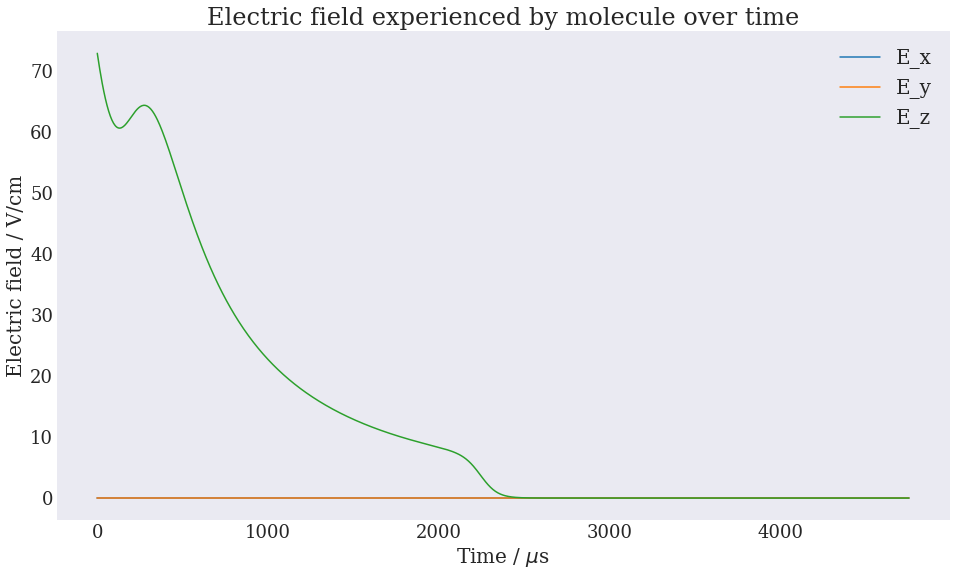

In [74]:
# Plot the electric field as a check:
electric_field.plot(trajectory)

## Define magnetic field
Define the magnetic field. Using a constant field, either a nominal small field (so mF states become non-degenerate eigenstates of the Hamiltonian) or something resembilng Earth's magnetic field.

In [75]:
# B = np.array((0,0,1e-3))
B = np.array((0.2,0.45,0.1))
magnetic_field = MagneticField(lambda R: np.repeat(B.reshape(3,1),R.shape[1], axis = 1))

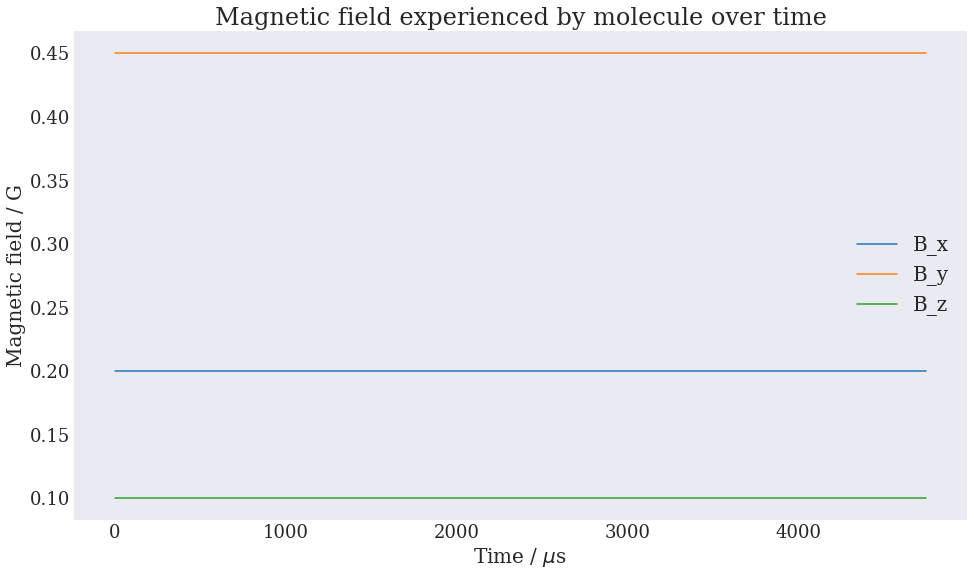

In [76]:
magnetic_field.plot(trajectory)

## Initial states
Define approximate initial states here.

In [77]:
#Define some useful approximate states
J1_singlet = 1/np.sqrt(2) * (1*UncoupledBasisState(J = 1, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = -1/2, P = -1, Omega = 0, electronic_state='X')
                                       -1* UncoupledBasisState(J = 1, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X'))

J1_triplet_0 = 1/np.sqrt(2) * (1*UncoupledBasisState(J = 1, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = -1/2, P = -1, Omega = 0, electronic_state='X')
                            +1* UncoupledBasisState(J = 1, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X'))

J1_triplet_p = 1*UncoupledBasisState(J = 1, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X')

J1_triplet_m = 1*UncoupledBasisState(J = 1, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = -1/2, P = -1, Omega = 0, electronic_state='X')

initial_states_approx = [J1_singlet, J1_triplet_m, J1_triplet_0, J1_triplet_p]

## Define slowly varying Hamiltonian
Define a Hamiltonian object that represents the slowly varying part of the Hamiltonian (i.e. everything except the microwaves). Using J = 0-3 here since we're interested in the time-evolution of J = 1 states; J = 1 and 3 are absolutely required since the electric field couples J = 1 to these, J = 0 is not strictly necessary. Since the Stark energies are << the rotational energies, we mostly just need the J of interest $\pm 1$.

In [78]:
Js = [0,1,2,3]
hamiltonian = SlowHamiltonian(Js)

## Time-evolution
Next define a Simulator and use it to numerically integrate the Schroedinger equation to see how the states evolve as the electric field is ramped down. 

In [79]:
simulator = Simulator(trajectory, electric_field, magnetic_field, initial_states_approx, hamiltonian)

In [80]:
result = simulator.run()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:10<00:00, 929.18it/s]


## Plot results

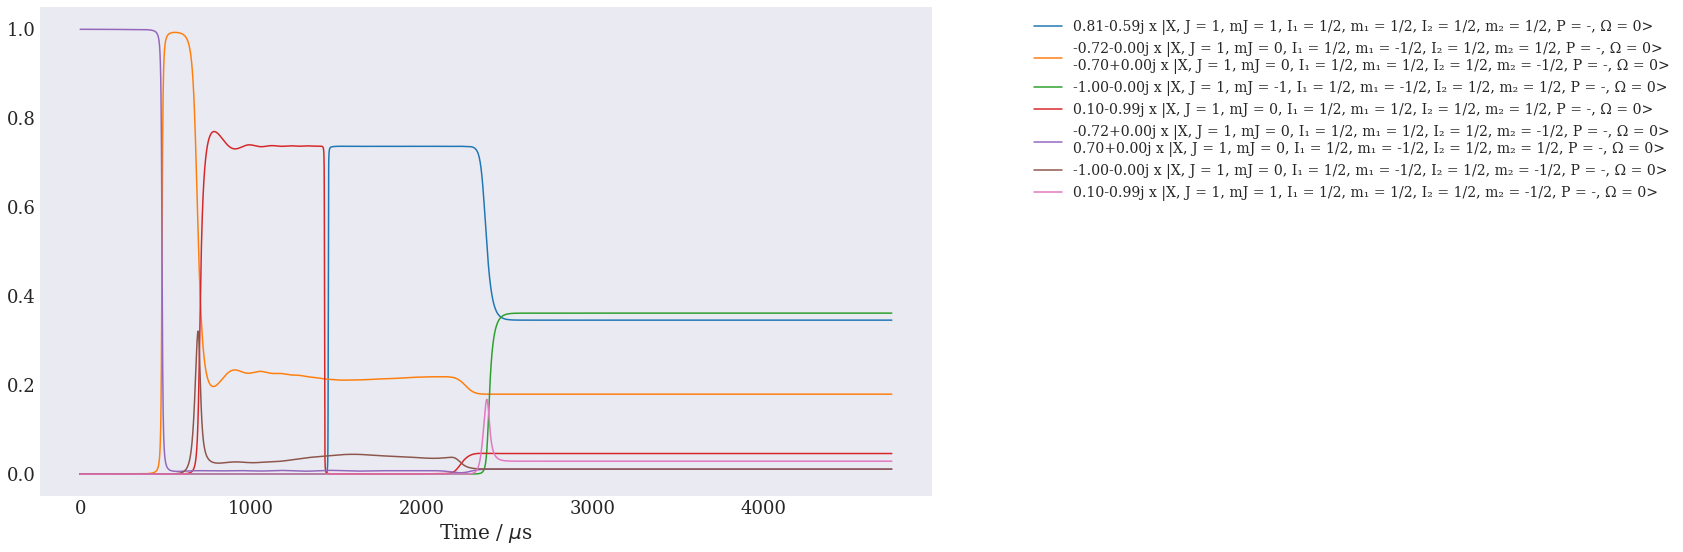

In [81]:
initial_state = result.initial_states[0]
large_prob_states = result.find_large_prob_states(initial_state, N = 7)
fig, ax = plt.subplots()
result.plot_state_probabilities(large_prob_states, initial_state, ax = ax)
ax.legend(fontsize = 14, bbox_to_anchor = (1.1,1))

## Convert final state vectors to coupled basis

In [82]:
def prob_F(state: centrex_TlF.State, F: float) -> float:
    """
    Calculates probability that molecule is found in state with given F.
    """
    prob = 0
    for amp, basis_state in state.data:
        prob += np.abs(amp)**2 *(basis_state.F == F)
        
    return prob

In [83]:
QN = result.hamiltonian.QN

# Starting in singlet
final_state_vec_singlet = result.psis[-1,0,:]
final_state_singlet = (vector_to_state(final_state_vec_singlet, QN).remove_small_components().transform_to_coupled()
                       .order_by_amp())
print("|J = 1, mJ = 0, S = 0 > ->")
final_state_singlet.make_real().print_state(probabilities=True)
print(f"\nProbability of F = 1: {prob_F(final_state_singlet, 1):.3f}")

#Starting in triplet_m
print('\n'+20*'*')
final_state_vec_triplet_m = result.psis[-1,1,:]
final_state_triplet_m = (vector_to_state(final_state_vec_triplet_m, QN).remove_small_components().transform_to_coupled()
                         .order_by_amp())
print("|J = 1, mJ = 0, S = 1, mS = -1 >  ->")
final_state_triplet_m.make_real().print_state(probabilities=True)
print(f"\nProbability of F = 2: {prob_F(final_state_triplet_m, 2):.3f}")


#Starting in triplet_0
print('\n'+20*'*')
final_state_vec_triplet_0 = result.psis[-1,2,:]
final_state_triplet_0 = (vector_to_state(final_state_vec_triplet_0, QN).remove_small_components().transform_to_coupled()
                         .order_by_amp())
print("|J = 1, mJ = 0, S = 1, mS = 0 >  ->")
final_state_triplet_0.make_real().print_state(probabilities=True)
print(f"\nProbability of F = 2: {prob_F(final_state_triplet_0, 2):.3f}")


#Starting in triplet_p
print('\n'+20*'*')
final_state_vec_triplet_p = result.psis[-1,3,:]
final_state_triplet_p = (vector_to_state(final_state_vec_triplet_p, QN).remove_small_components().transform_to_coupled()
                         .order_by_amp())
print("|J = 1, mJ = 0, S = 1, mS = 1 >  ->")
final_state_triplet_p.make_real().print_state(probabilities=True)
print(f"\nProbability of F = 2: {prob_F(final_state_triplet_p, 2):.3f}")

|J = 1, mJ = 0, S = 0 > ->
+0.7096+0.0000j x |X, J = 1, F₁ = 3/2, F = 1, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
+0.0960+0.0000j x |X, J = 1, F₁ = 3/2, F = 2, mF = -1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
+0.0933+0.0000j x |X, J = 1, F₁ = 3/2, F = 2, mF = -2, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
+0.0537+0.0000j x |X, J = 1, F₁ = 3/2, F = 2, mF = 1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
+0.0178+0.0000j x |X, J = 1, F₁ = 3/2, F = 1, mF = 1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
+0.0116+0.0000j x |X, J = 1, F₁ = 3/2, F = 2, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>

Probability of F = 1: 0.742

********************
|J = 1, mJ = 0, S = 1, mS = -1 >  ->
+0.3090+0.0000j x |X, J = 1, F₁ = 3/2, F = 2, mF = 1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
+0.2119+0.0000j x |X, J = 1, F₁ = 3/2, F = 2, mF = -1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
+0.1927+0.0000j x |X, J = 1, F₁ = 3/2, F = 1, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
+0.1417+0.0000j x |X, J = 1, F₁ = 3/2, F = 2, mF = 2, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
+0